# Layered Embeddings

## Initialise

In [1]:
!pip install graphdatascience python-dotenv umap-learn scikit-learn==1.4.2 matplotlib seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from graphdatascience import GraphDataScience, Graph

def drop_graph_if_exists(gds: GraphDataScience,
                         projections: list):
  """Drop named GDS projections in list.

  Args:
    gds : GraphDataScience
      Neo4j GDS session object
    projections: list
      List of projection names
  """
  # Check for existence of each named projection
  filtered_projections = list(filter(lambda x: x in projections, gds.graph.list()['graphName']))
  # Drop projections
  _ = list(map(lambda x: gds.graph.drop(gds.graph.get(x)), filtered_projections))


def reduce_embedding(df: pd.DataFrame, algorithm, property_column='propertyValue', reduce_column='reduced'):
  # Apply dimensionality reduction algorithm to embedding
  transformed = algorithm.fit_transform(np.array(list(df[property_column])))

  # Concatenate reduced transformation into Dataframe
  dfX = pd.concat([df, pd.Series(list(transformed))], axis=1, ignore_index=True, join='outer')

  # Name columns following concatenation
  dfX = dfX.set_axis(list(df.columns) + [reduce_column], axis=1)
  return dfX


def cluster_embedding(df: pd.DataFrame, algorithm, property_column='propertyValue', cluster_column='cluster'):
  # Apply clustering algorithm to embedding
  algorithm.fit(np.array(list(df[property_column])))

  # Concatenate cluster labels into Dataframe
  dfX = pd.concat([df, pd.DataFrame(list(algorithm.labels_))], axis=1, ignore_index=True, join='outer')

  # Name columns following concatenation
  dfX = dfX.set_axis(list(df.columns) + [cluster_column], axis=1)
  return dfX

In [3]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, homogeneity_completeness_v_measure

def get_cluster_overlap_metrics(labels_algorithm_1, labels_algorithm_2):
    # Adjusted Rand Index
    ari = adjusted_rand_score(labels_algorithm_1, labels_algorithm_2)
    print(f"Adjusted Rand Index (ARI): {ari:.3f}")
    
    # Normalized Mutual Information
    nmi = normalized_mutual_info_score(labels_algorithm_1, labels_algorithm_2)
    print(f"Normalized Mutual Information (NMI): {nmi:.3f}")
    
    # Fowlkes-Mallows Index
    fmi = fowlkes_mallows_score(labels_algorithm_1, labels_algorithm_2)
    print(f"Fowlkes-Mallows Index (FMI): {fmi:.3f}")
    
    # Homogeneity, Completeness, and V-Measure
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(labels_algorithm_1, labels_algorithm_2)
    print(f"Homogeneity: {homogeneity:.3f}")
    print(f"Completeness: {completeness:.3f}")
    print(f"V-Measure: {v_measure:.3f}")


In [4]:
from sklearn.cluster import HDBSCAN
import umap.umap_ as umap
import time

from dotenv import load_dotenv
import os
import random
import pandas as pd
pd. set_option('display.max_rows', 100)
load_dotenv()

NEO4J_URI = os.environ.get("NEO4J_URI", "bolt://localhost:7687")
NEO4J_AUTH = None
NEO4J_DB = os.environ.get("NEO4J_DB", "neo4j")
if os.environ.get("NEO4J_USER") and os.environ.get("NEO4J_PASSWORD"):
    NEO4J_AUTH = (
        os.environ.get("NEO4J_USER"),
        os.environ.get("NEO4J_PASSWORD"),
    )

from neo4j import GraphDatabase
driver = GraphDatabase.driver(NEO4J_URI, auth=NEO4J_AUTH)
n4j = driver.session(database=NEO4J_DB)


gds = GraphDataScience(NEO4J_URI, auth=NEO4J_AUTH, database=NEO4J_DB)

In [5]:
import numpy

SEED = 123
numpy.random.seed(SEED)
random.seed(SEED)

## Create Graph

In [6]:
nA = 10000
nB = 10000
nZ = 7
connections = 4

n4j.run('MATCH (n) DETACH DELETE n')

n4j.run("CREATE CONSTRAINT a_name IF NOT EXISTS FOR (n:A) REQUIRE (n.name) IS UNIQUE")
n4j.run("CREATE CONSTRAINT b_name IF NOT EXISTS FOR (n:B) REQUIRE (n.name) IS UNIQUE")
n4j.run("CREATE CONSTRAINT z_name IF NOT EXISTS FOR (n:Z) REQUIRE (n.name) IS UNIQUE")

n4j.run("UNWIND $records AS row MERGE (:A {name: row})", records=list(range(nA)))
n4j.run("UNWIND $records AS row MERGE (:B {name: row})", records=list(range(nB)))
n4j.run("UNWIND $records AS row MERGE (:Z {name: row})", records=list(range(nZ)))

n4j.run("UNWIND $records AS row MATCH (a:A {name: row}) MATCH (b:B {name: row}) MERGE (a)-[:FOLLOW]->(b)", records=list(range(nA)))

# Generate random traits
traits = list(map(lambda x: [x, random.sample(range(nZ), connections)], range(nA)))

n4j.run("UNWIND $records AS row MATCH (b:B {name: row[0]}) UNWIND row[1] AS x MATCH (z:Z {name: x}) MERGE (b)-[:TRAIT]->(z)", records=traits)
time.sleep(2)

### Project

In [7]:
PROJECTION1 = 'ABZ'
list(map(lambda x: gds.graph.drop(gds.graph.get(x)), list(filter(lambda x: x in [PROJECTION1], gds.graph.list()['graphName']))))
cypher = """
CALL {
    MATCH (a:A)-[r1:FOLLOW]->(b:B)
    RETURN a AS source, labels(a) AS sourceLabel, b AS target, labels(b) AS targetLabel, type(r1) AS relType
    UNION ALL
    MATCH (a:A)-[r1:FOLLOW]->(b:B)-[r2:TRAIT]->(z:Z)
    RETURN b AS source, labels(b) AS sourceLabel, z AS target, labels(z) AS targetLabel, type(r2) AS relType
}
RETURN gds.graph.project($projection_name, source, target,
  {sourceNodeLabels: sourceLabel,
  targetNodeLabels: targetLabel,
  relationshipType: relType},
  {undirectedRelationshipTypes: ['*']})
"""

G, result = gds.graph.cypher.project(cypher, projection_name=PROJECTION1)
result
gds.graph.list()

,degreeDistribution,graphName,database,databaseLocation,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation
0,"{'min': 1, 'max': 5784, 'p90': 5, 'p999': 5, '...",ABZ,neo4j,local,8845 KiB,9058125,20007,100000,"{'readConcurrency': 4, 'undirectedRelationship...",0.00025,2024-09-10T14:04:56.926620000+01:00,2024-09-10T14:04:56.926620000+01:00,"{'graphProperties': {}, 'nodes': {'A': {}, 'B'...","{'graphProperties': {}, 'nodes': {'A': {}, 'B'..."


## Approach A - Direct

### Embed

In [8]:
EMBEDDING = 'fastRP_BZ'
EMBEDDING_DIMENSION = 128
RANDOM_SEED = 42
gds.fastRP.mutate(G, iterationWeights=[1.0], embeddingDimension=EMBEDDING_DIMENSION, mutateProperty=EMBEDDING, randomSeed=RANDOM_SEED, nodeLabels=['B', 'Z'], concurrency=1)
dfBe = gds.graph.nodeProperty.stream(G, EMBEDDING, 'B')
dfBe.head()

,nodeId,propertyValue
0,10000,"[0.07198158, -0.07198158, 0.0, -0.14396316, -0..."
1,10001,"[0.13703774, -0.06851887, 0.0, -0.13703774, -0..."
2,10002,"[0.145865, -0.0729325, 0.0, -0.0729325, -0.072..."
3,10003,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.16064386, -0.08032..."
4,10004,"[0.07738232, 0.0, 0.0, 0.0, 0.0, 0.15476464, -..."


## Approach B - Layered

### Embed B to Z

In [9]:
dfB2 = gds.graph.nodeProperty.stream(G, EMBEDDING, 'B')
dfB2['labels'] = dfB2.apply(lambda x: ['B'], axis='columns')
dfB2.head()

,nodeId,propertyValue,labels
0,10000,"[0.07198158, -0.07198158, 0.0, -0.14396316, -0...",[B]
1,10001,"[0.13703774, -0.06851887, 0.0, -0.13703774, -0...",[B]
2,10002,"[0.145865, -0.0729325, 0.0, -0.0729325, -0.072...",[B]
3,10003,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.16064386, -0.08032...",[B]
4,10004,"[0.07738232, 0.0, 0.0, 0.0, 0.0, 0.15476464, -...",[B]


### Stream A nodes

Add zero vectors

In [10]:
gds.wcc.mutate(G, mutateProperty='wcc')
dfA1 = gds.graph.nodeProperty.stream(G, 'wcc', 'A')
dfA1['propertyValue'] = dfA1.apply(lambda x: list(map(lambda x: 0.0, range(int(EMBEDDING_DIMENSION)))), axis='columns')
dfA1['labels'] = dfA1.apply(lambda x: ['A'], axis='columns')
dfA1.head()

,nodeId,propertyValue,labels
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]


### Stream FOLLOW relationships

In [11]:
relationships = gds.graph.relationships.stream(G, ['FOLLOW'])
relationships.head()

,sourceNodeId,targetNodeId,relationshipType
0,0,10000,FOLLOW
1,10000,0,FOLLOW
2,1,10001,FOLLOW
3,10001,1,FOLLOW
4,2,10002,FOLLOW


### Construct Graph

In [12]:
PROJECTION3 = 'AB'
list(map(lambda x: gds.graph.drop(gds.graph.get(x)), list(filter(lambda x: x in [PROJECTION3], gds.graph.list()['graphName']))))
GC = gds.graph.construct(PROJECTION3, pd.concat([dfB2, dfA1]), relationships)
gds.graph.list()

Uploading Nodes:   0%|          | 0/20000 [00:00<?, ?Records/s]

Uploading Relationships:   0%|          | 0/20000 [00:00<?, ?Records/s]

/Users/olgarazvenskaia/.env/fastrp-repr/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'TopologyDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'TopologyDataFrame.transpose' instead.
  return bound(*args, **kwds)


,degreeDistribution,graphName,database,databaseLocation,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation
0,"{'min': 1, 'max': 5784, 'p90': 5, 'p999': 5, '...",ABZ,neo4j,local,None,-1,20007,100000,"{'readConcurrency': 4, 'undirectedRelationship...",0.00025,2024-09-10T14:04:56.926620000+01:00,2024-09-10T14:04:57.415480000+01:00,"{'graphProperties': {}, 'nodes': {'A': {'wcc':...","{'graphProperties': {}, 'nodes': {'A': {'wcc':..."
1,"{'min': 1, 'max': 1, 'p90': 1, 'p999': 1, 'p99...",AB,neo4j,none,26 MiB,27767083,20000,20000,"{'readConcurrency': 4, 'jobId': '1c290077-54f2...",0.00005,2024-09-10T14:05:00.715489000+01:00,2024-09-10T14:05:00.715489000+01:00,"{'graphProperties': {}, 'nodes': {'A': {'prope...","{'graphProperties': {}, 'nodes': {'A': {'prope..."


### Embed combining graph & previously calculated embeddings

In [13]:
NODE_SELF_INFLUENCE = 0.0


EMBEDDING_00 = 'fastRP_00'
PROPERTY_RATIO_00 = 0.0
gds.fastRP.mutate(GC,
                  randomSeed = RANDOM_SEED,
                  embeddingDimension=EMBEDDING_DIMENSION, iterationWeights=[1.0], mutateProperty=EMBEDDING_00,
                  nodeSelfInfluence=NODE_SELF_INFLUENCE, propertyRatio=PROPERTY_RATIO_00, featureProperties=['propertyValue'], concurrency=1)

EMBEDDING_01 = 'fastRP_01'
PROPERTY_RATIO_01 = 0.1
gds.fastRP.mutate(GC,
                  randomSeed = RANDOM_SEED,
                  embeddingDimension=EMBEDDING_DIMENSION, iterationWeights=[1.0], mutateProperty=EMBEDDING_01,
                  nodeSelfInfluence=NODE_SELF_INFLUENCE, propertyRatio=PROPERTY_RATIO_01, featureProperties=['propertyValue'], concurrency=1)

EMBEDDING_05 = 'fastRP_05'
PROPERTY_RATIO_05 = 0.5
gds.fastRP.mutate(GC,
                  randomSeed = RANDOM_SEED,
                  embeddingDimension=EMBEDDING_DIMENSION, iterationWeights=[1.0], mutateProperty=EMBEDDING_05,
                  nodeSelfInfluence=NODE_SELF_INFLUENCE, propertyRatio=PROPERTY_RATIO_05, featureProperties=['propertyValue'], concurrency=1)

EMBEDDING_07 = 'fastRP_07'
PROPERTY_RATIO_07 = 0.7
gds.fastRP.mutate(GC,
                  randomSeed = RANDOM_SEED,
                  embeddingDimension=EMBEDDING_DIMENSION, iterationWeights=[1.0], mutateProperty=EMBEDDING_07,
                  nodeSelfInfluence=NODE_SELF_INFLUENCE, propertyRatio=PROPERTY_RATIO_07, featureProperties=['propertyValue'], concurrency=1)

EMBEDDING_09 = 'fastRP_09'
PROPERTY_RATIO_09 = 0.9
gds.fastRP.mutate(GC,
                  randomSeed = RANDOM_SEED,
                  embeddingDimension=EMBEDDING_DIMENSION, iterationWeights=[1.0], mutateProperty=EMBEDDING_09,
                  nodeSelfInfluence=NODE_SELF_INFLUENCE, propertyRatio=PROPERTY_RATIO_09, featureProperties=['propertyValue'], concurrency=1)

EMBEDDING_095 = 'fastRP_095'
PROPERTY_RATIO_095 = 0.95
gds.fastRP.mutate(GC,
                  randomSeed = RANDOM_SEED,
                  embeddingDimension=EMBEDDING_DIMENSION, iterationWeights=[1.0], mutateProperty=EMBEDDING_095,
                  nodeSelfInfluence=NODE_SELF_INFLUENCE, propertyRatio=PROPERTY_RATIO_095, featureProperties=['propertyValue'], concurrency=1)

EMBEDDING_099 = 'fastRP_099'
PROPERTY_RATIO_099 = 0.99
gds.fastRP.mutate(GC,
                  randomSeed = RANDOM_SEED,
                  embeddingDimension=EMBEDDING_DIMENSION, iterationWeights=[1.0], mutateProperty=EMBEDDING_099,
                  nodeSelfInfluence=NODE_SELF_INFLUENCE, propertyRatio=PROPERTY_RATIO_099, featureProperties=['propertyValue'], concurrency=1)

EMBEDDING_10 = 'fastRP_10'
PROPERTY_RATIO_10 = 1.0
gds.fastRP.mutate(GC,
                  randomSeed = RANDOM_SEED,
                  embeddingDimension=EMBEDDING_DIMENSION, iterationWeights=[1.0], mutateProperty=EMBEDDING_10,
                  nodeSelfInfluence=NODE_SELF_INFLUENCE, propertyRatio=PROPERTY_RATIO_10, featureProperties=['propertyValue'], concurrency=1)

FastRP:   0%|          | 0/100 [00:00<?, ?%/s]

FastRP:   0%|          | 0/100 [00:00<?, ?%/s]

FastRP:   0%|          | 0/100 [00:00<?, ?%/s]

FastRP:   0%|          | 0/100 [00:00<?, ?%/s]

FastRP:   0%|          | 0/100 [00:00<?, ?%/s]

nodePropertiesWritten                                                20000
mutateMillis                                                             0
nodeCount                                                            20000
preProcessingMillis                                                      0
computeMillis                                                          819
configuration            {'randomSeed': 42, 'mutateProperty': 'fastRP_1...
Name: 0, dtype: object

In [14]:
embeddings = {}
emb_names = [EMBEDDING_00, EMBEDDING_01, EMBEDDING_05, EMBEDDING_07,  EMBEDDING_09, EMBEDDING_095, EMBEDDING_099, EMBEDDING_10] 

for propName in emb_names:
    embeddings[propName] = gds.graph.nodeProperty.stream(GC, propName, 'A')
    # print(_ddf.head())

In [47]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def hist(x):
    plt.hist(x, density=True, bins=30)  # density=False would make counts
    plt.ylabel('Number of Occurrences')
    plt.xlabel('Discrepancy')

In [50]:
def discrepancy(df1, df2, node_pairs):
    df1 = df1.set_index('nodeId')
    df2 = df2.set_index('nodeId')

    sims1 = [np.linalg.norm(df1.loc[pair[0]]['propertyValue'] - df1.loc[pair[1]]['propertyValue']) for pair in node_pairs]
    sims2 = [np.linalg.norm(df2.loc[pair[0]]['propertyValue'] - df2.loc[pair[1]]['propertyValue']) for pair in node_pairs]
    # normalizer = np.mean(sims1)
    # discrepancies = [abs(s1 - s2)/normalizer for s1, s2 in zip(sims1, sims2)]
    discrepancies = []
    for i in range(len(node_pairs)):
        s1 = sims1[i]
        s2 = sims2[i]
        if not min(s1, s2) == 0:   
            discrepancies.append(abs(s1 - s2)/min(s1, s2))
    hist(discrepancies)
    return np.mean(discrepancies)

Discrepancy between fastRP_00 and fastRP_01: 0.021394338458776474
Discrepancy between fastRP_01 and fastRP_05: 0.11067194491624832
Discrepancy between fastRP_05 and fastRP_07: 0.07985272258520126
Discrepancy between fastRP_07 and fastRP_09: 0.11382853984832764
Discrepancy between fastRP_09 and fastRP_095: 0.03078639507293701
Discrepancy between fastRP_095 and fastRP_099: 0.029311789199709892
Discrepancy between fastRP_099 and fastRP_10: 0.0174148827791214


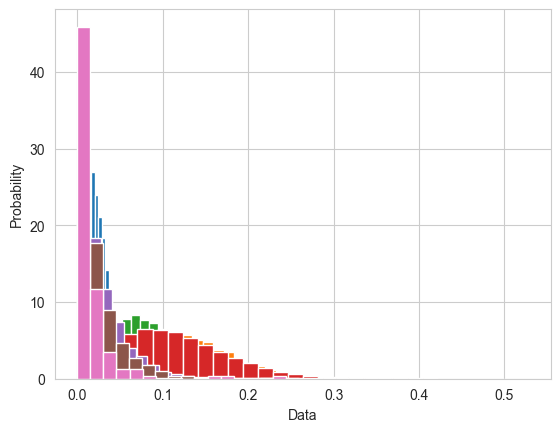

In [31]:
samples = 10000
node_count = nA

node_ids = embeddings[emb_names[0]]['nodeId'].tolist()
node_pairs = [(np.random.choice(node_ids), np.random.choice(node_ids)) for _ in range(samples)]

for i in range(len(emb_names) - 1):
    df1 = embeddings[emb_names[i]]
    df2 = embeddings[emb_names[i+1]]
    
    print(f"Discrepancy between {emb_names[i]} and {emb_names[i+1]}: {discrepancy(df1, df2, node_pairs)}")
    

Discrepancy between propertyRatio=0.95 and propertyRatio=1.0: 0.038929350674152374


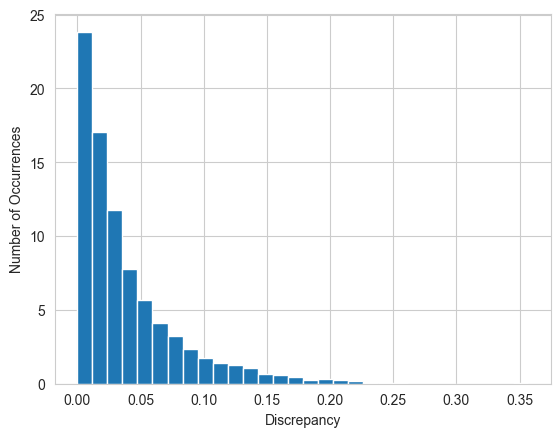

In [52]:
emb1 = EMBEDDING_095
emb2 = EMBEDDING_10
print(f"Discrepancy between propertyRatio=0.95 and propertyRatio=1.0: {discrepancy(embeddings[emb1], embeddings[emb2], node_pairs)}")

In [22]:
import pandas as pd
import numpy as np

node_count = 10000

df1 = pd.DataFrame({"nodeId": list(range(node_count)), "emb": [np.random.randn(128) for _ in range(node_count)]}).set_index("nodeId")
df2 = pd.DataFrame({"nodeId": list(range(node_count)), "emb": [np.random.randn(128) for _ in range(node_count)]}).set_index("nodeId")

node_pairs = []
samples = 10000
for _ in range(samples):
    node_pairs.append((np.random.randint(node_count), np.random.randint(node_count)))

def discrepancy(df1, df2, node_pairs):
    sims1 = [np.linalg.norm(df1.loc[src]['emb'] - df1.loc[trg]['emb']) for src, trg in node_pairs]
    sims2 = [np.linalg.norm(df2.loc[src]['emb'] - df2.loc[trg]['emb']) for src, trg in node_pairs]
    normalizer = np.mean(sims1)
    discrepancies = [abs(s1 - s2)/normalizer for s1, s2 in zip(sims1, sims2)]
    return np.mean(discrepancies)

print(discrepancy(df1, df2, node_pairs))

0.07086537607858717


In [23]:
def get_cluster_assignments(graphName, propertyName, nodeLabel):
    _ddf = gds.graph.nodeProperty.stream(graphName, propertyName, nodeLabel)
    _ddf2 = cluster_embedding(_ddf, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), cluster_column='raw')
    _ddf2 = reduce_embedding(_ddf2, umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2))
    _ddf2 = cluster_embedding(_ddf2, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), property_column='reduced', cluster_column='umap')
    
    _ddf2['x'] = _ddf2['reduced'].apply(lambda x: x[0])
    _ddf2['y'] = _ddf2['reduced'].apply(lambda x: x[1])
    _ddf2.plot.scatter(x='x', y='y', c=_ddf2['umap'], cmap="plasma", marker='+', title=propertyName+' '+nodeLabel)
    
    return _ddf2

# def get_cluster_assignments_not_reduced(graphName, propertyName, nodeLabel):
#     _ddf = gds.graph.nodeProperty.stream(graphName, propertyName, nodeLabel)
#     _ddf2 = cluster_embedding(_ddf, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), cluster_column='umap')
#     
#     return _ddf2

labels_B fastRP_BZ



fastRP_00



fastRP_01



fastRP_05



fastRP_07



fastRP_09



fastRP_095



fastRP_099



fastRP_10


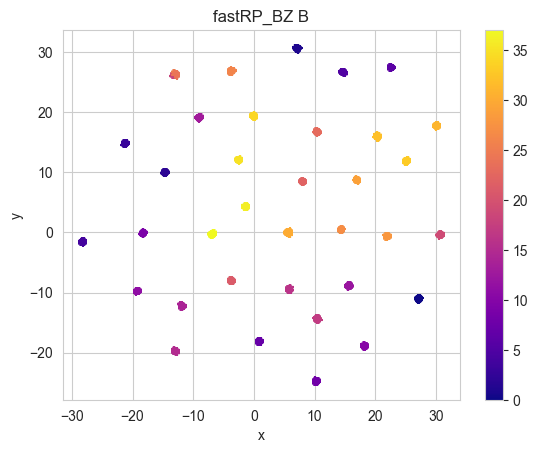

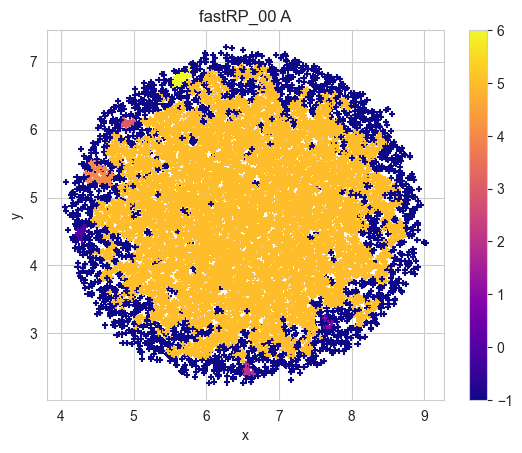

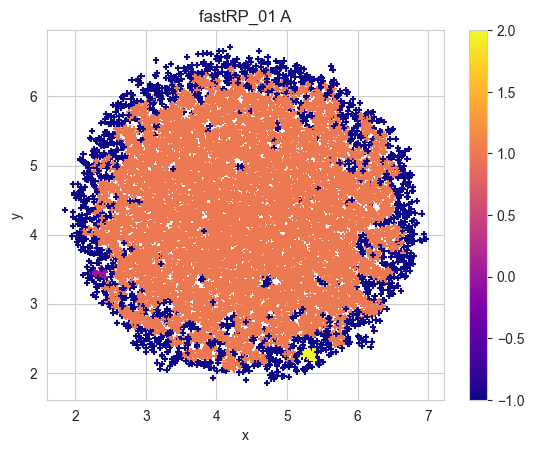

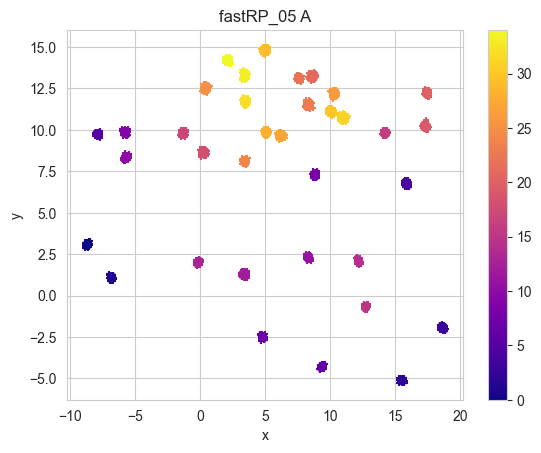

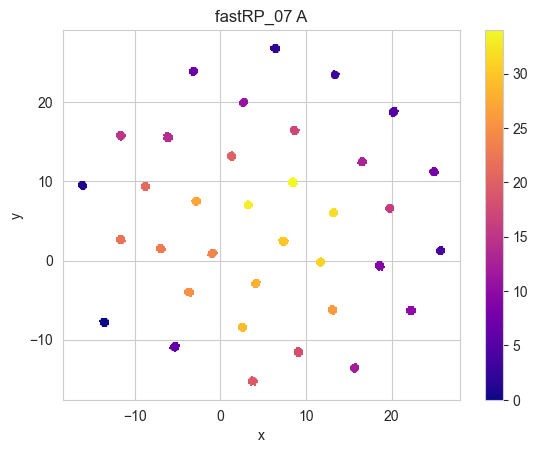

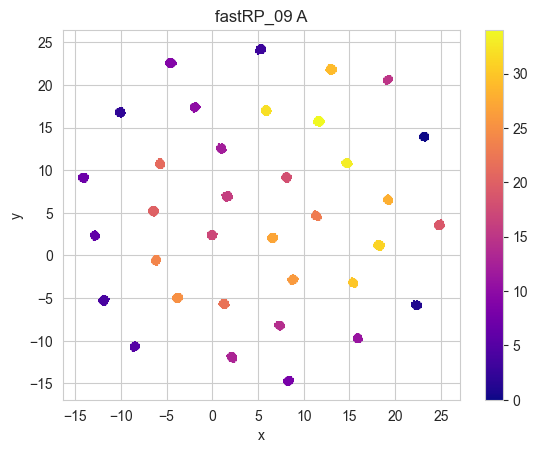

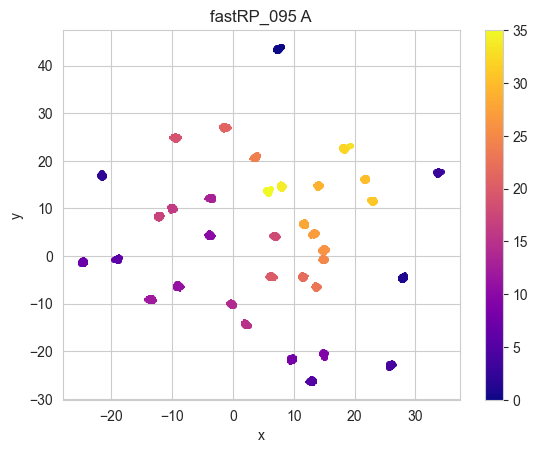

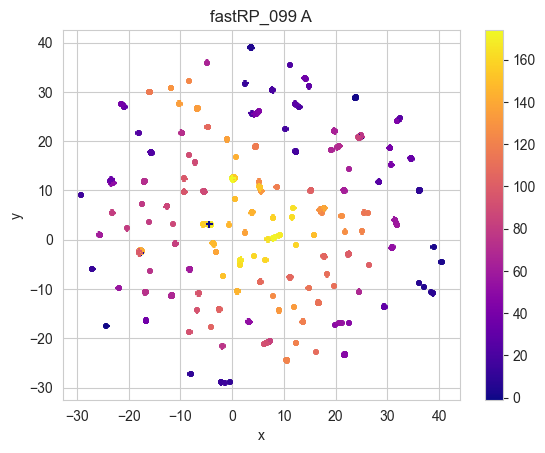

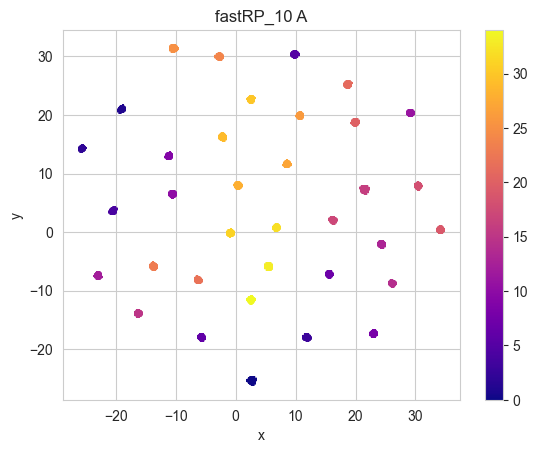

In [25]:
print("labels_B " + EMBEDDING)
labels_B = get_cluster_assignments(G, EMBEDDING, 'B')

labels = {}
for propName in [EMBEDDING_00, EMBEDDING_01, EMBEDDING_05, EMBEDDING_07,  EMBEDDING_09, EMBEDDING_095, EMBEDDING_099, EMBEDDING_10]:
    print("\n\n\n"+propName)
    labels[propName] = get_cluster_assignments(GC, propName, 'A')
    relmap = dict(map(lambda x: (x['sourceNodeId'], x['targetNodeId']), relationships.to_dict(orient='records')))
    labels[propName]['FOLLOW'] = labels[propName].apply(lambda x: relmap[x['nodeId']], axis=1)
    labels[propName].head()

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_cluster_overlap(lA, lB):

    I = {}
    for x in lA['umap'].value_counts().index:
      I[x] = {}
      for y in lB['umap'].value_counts().index:
        sA = set(lA[lA['umap'] == x]['FOLLOW'])
        sB = set(lB[lB['umap'] == y]['nodeId'])
        I[x][y] = 100 * len(sA & sB) / len(sA | sB)

    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(pd.DataFrame(I), cmap='coolwarm')




Comparing fastRP_00 with B->Z embedding
Adjusted Rand Index (ARI): -0.000
Normalized Mutual Information (NMI): 0.005
Fowlkes-Mallows Index (FMI): 0.133
Homogeneity: 0.018
Completeness: 0.003
V-Measure: 0.005



Comparing fastRP_01 with B->Z embedding
Adjusted Rand Index (ARI): 0.000
Normalized Mutual Information (NMI): 0.006
Fowlkes-Mallows Index (FMI): 0.141
Homogeneity: 0.026
Completeness: 0.004
V-Measure: 0.006



Comparing fastRP_05 with B->Z embedding
Adjusted Rand Index (ARI): 0.993
Normalized Mutual Information (NMI): 0.996
Fowlkes-Mallows Index (FMI): 0.993
Homogeneity: 1.000
Completeness: 0.992
V-Measure: 0.996



Comparing fastRP_07 with B->Z embedding
Adjusted Rand Index (ARI): 0.993
Normalized Mutual Information (NMI): 0.996
Fowlkes-Mallows Index (FMI): 0.993
Homogeneity: 1.000
Completeness: 0.992
V-Measure: 0.996



Comparing fastRP_09 with B->Z embedding
Adjusted Rand Index (ARI): 0.993
Normalized Mutual Information (NMI): 0.996
Fowlkes-Mallows Index (FMI): 0.993
Homog

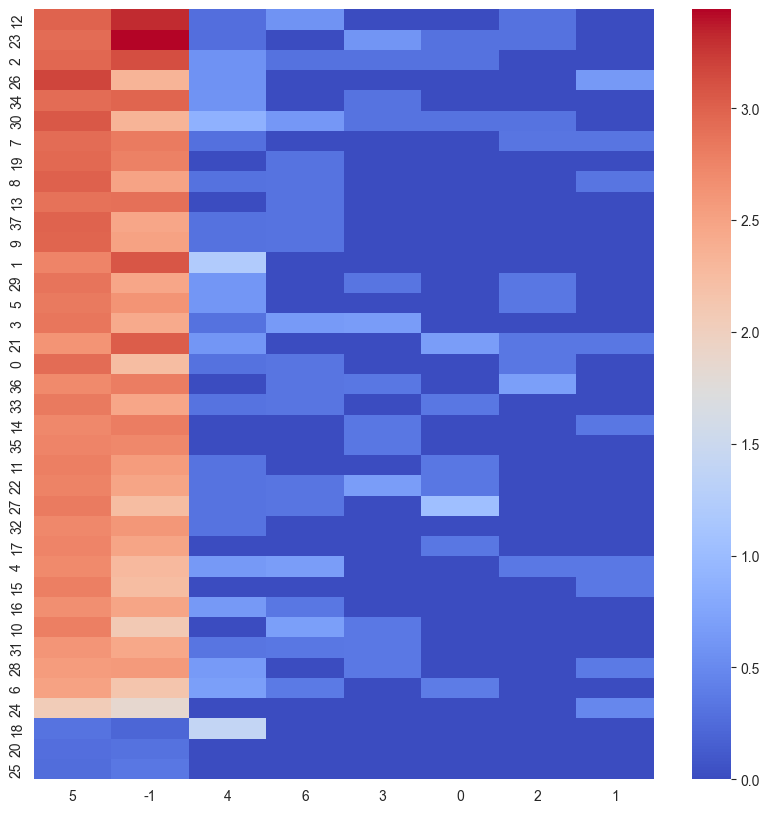

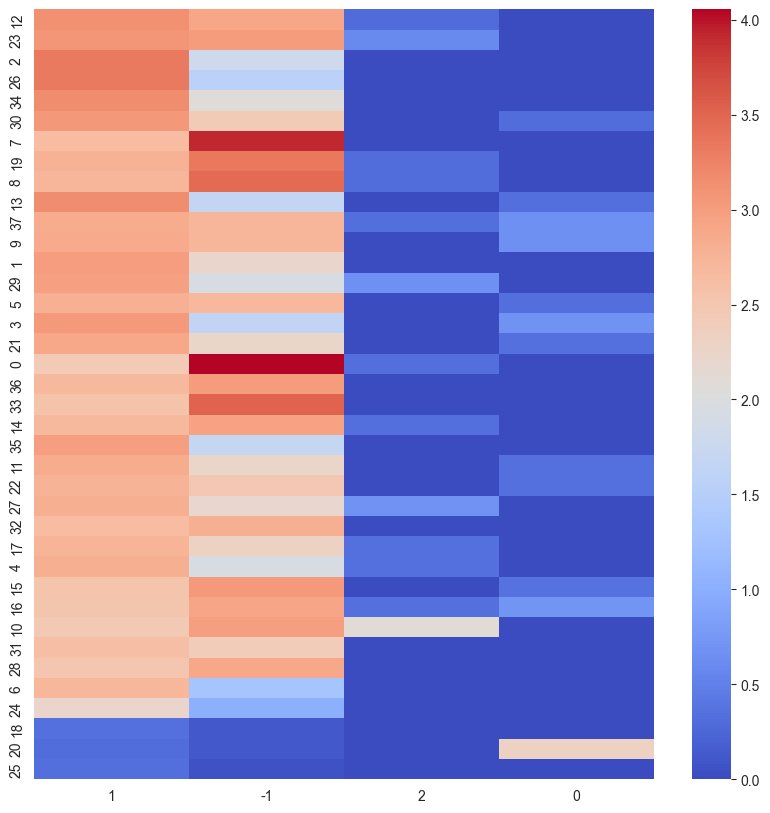

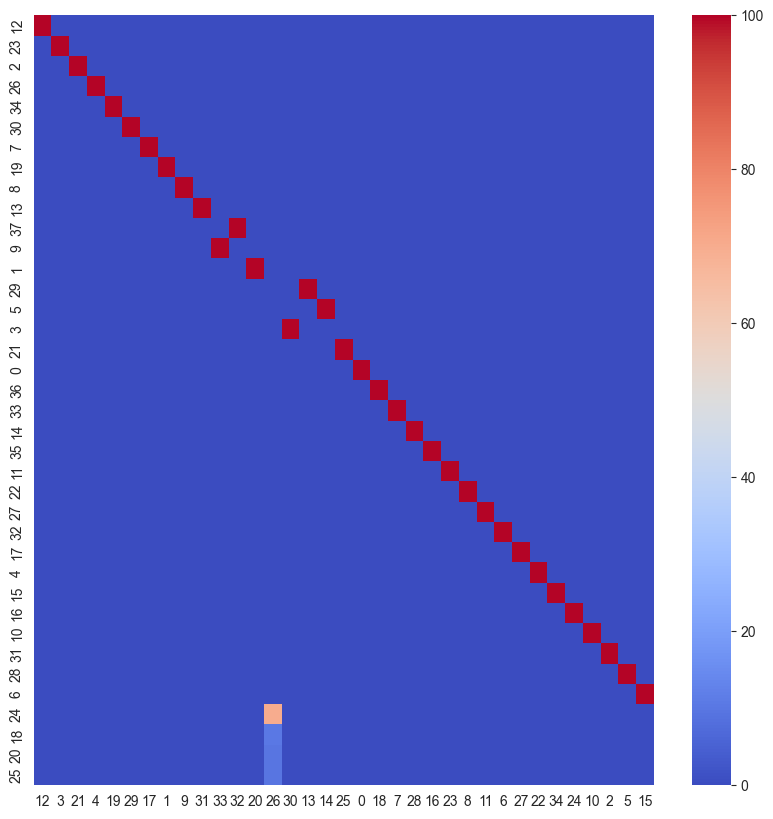

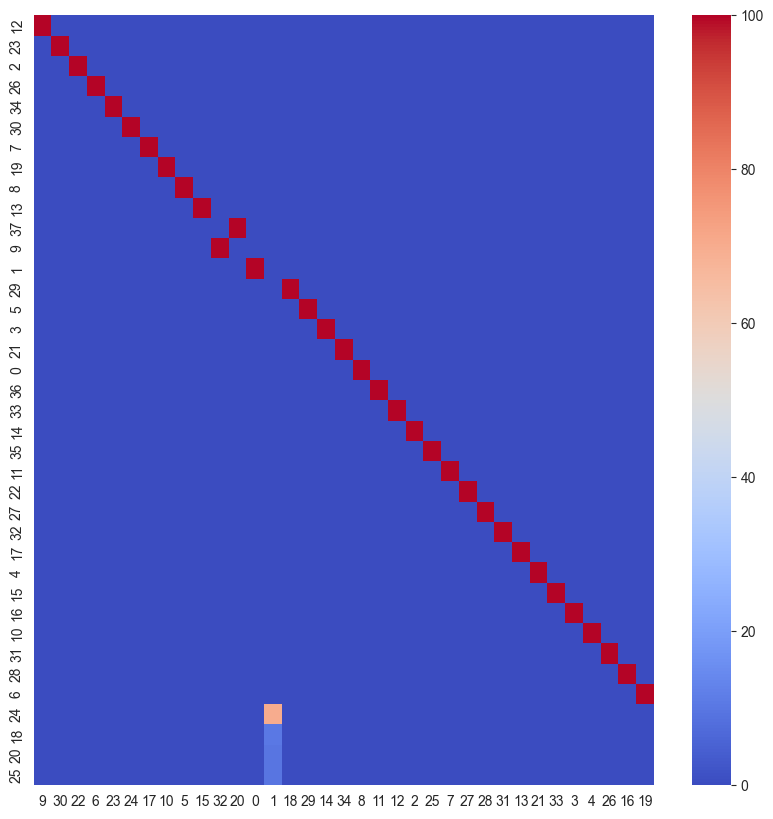

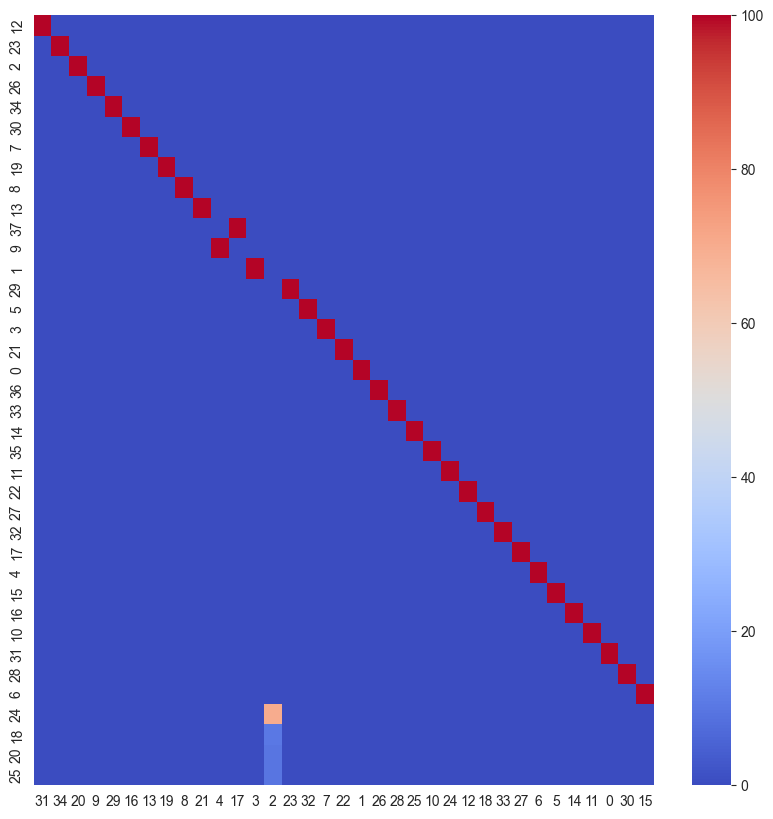

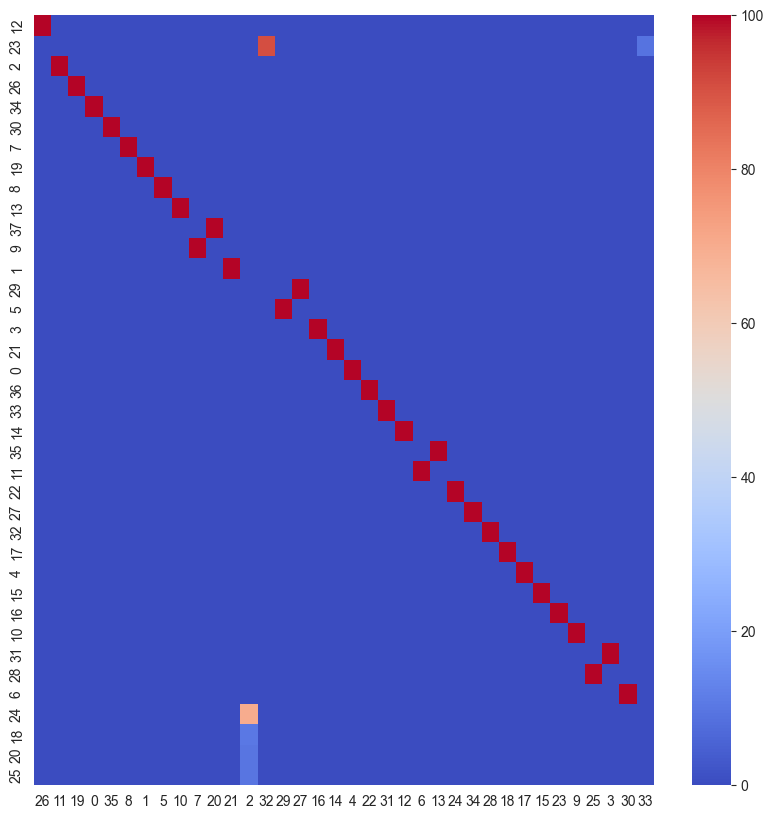

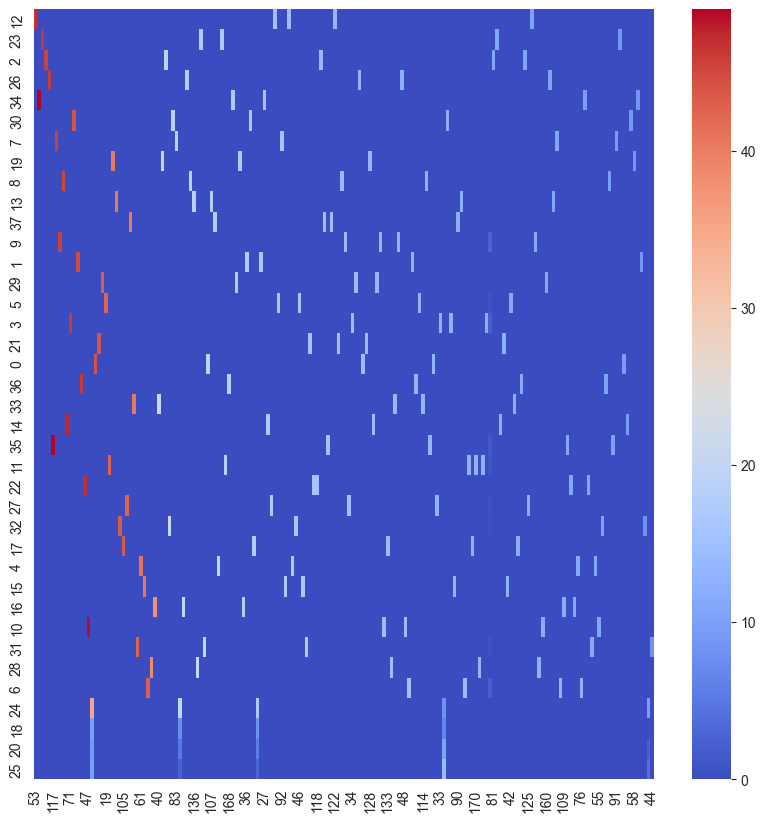

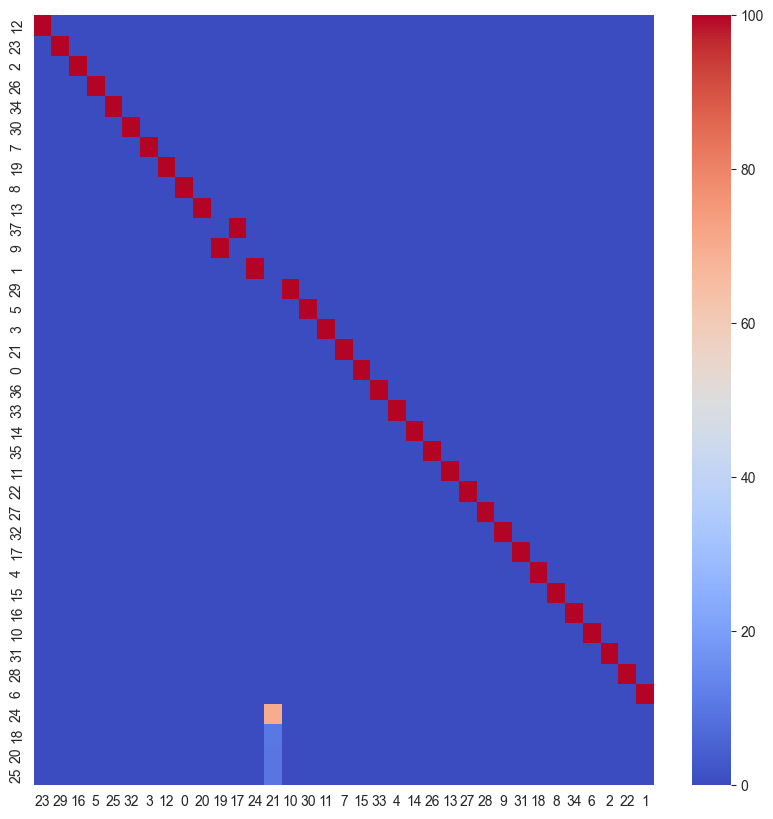

In [27]:
for propName, labels_A in labels.items():
    print(f"\n\n\nComparing {propName} with B->Z embedding")
    get_cluster_overlap_metrics(labels_A['umap'], labels_B['umap'])
    get_cluster_overlap(labels_A, labels_B)
    

In [ ]:
import pandas as pd
import numpy as np

# node_count = 1000
# 
# df1 = pd.DataFrame({"nodeId": list(range(node_count)), "emb": [np.random.randn(8) for _ in range(node_count)]}).set_index("nodeId")
# df2 = pd.DataFrame({"nodeId": list(range(node_count)), "emb": [np.random.randn(8) for _ in range(node_count)]}).set_index("nodeId")

node_pairs = []
samples = 100
for _ in range(samples):
    node_pairs.append((np.random.randint(df1.shape[0]), np.random.randint(df1.shape[0])))

def discrepancy(df1, df2, node_pairs):
    sims1 = [np.linalg.norm(df1.loc[src] - df1.loc[trg]) for src, trg in node_pairs]
    sims2 = [np.linalg.norm(df2.loc[src] - df2.loc[trg]) for src, trg in node_pairs]
    normalizer = np.mean(sims1)
    discrepancies = [abs(s1 - s2)/normalizer for s1, s2 in zip(sims1, sims2)]
    return np.mean(discrepancies)

print(discrepancy(df1, df2, node_pairs))